## Dataset creation

To build the song dataset for the project, existing datasets will have some features merged together. These are the Deezer dataset used in "End-to-end Multimodal Music Mood Detection Based On Audio And Lyrics" by Delbouys et. al (2018) (https://github.com/deezer/deezer_mood_detection_dataset) [1] and the 1% subset of the Million Song Dataset (https://labrosa.ee.columbia.edu/millionsong/) [2]. 

## Exploring the Deezer dataset

The Deezer dataset contains information on 18,644 songs (11267 training + 3863 validation + 3514 testing), which all together takes up only 2MB of space. Without getting too deep into the details of the paper, what's especially attractive about this dataset is how each of these songs have associated normalized valence and arousal values. Valence can be understood as a spectrum with one end for increasingly positive feelings (happiness, joy, contentment) and the opposite end for increasingly negative feelings (sorrow, disappointment). Arousal can be understood as the presence or absence of energy (hyped up versus chilled out).

Emotions can be mapped to the 2-dimensional space afforded by this representation and such values can themselves be found by using MFCC-based analysis (a song's timbre elements spread across frequencies), semantic lyric analysis, or a combination of the two approaches (the Deezer dataset's valence/arousal values are obtained with a hybrid approach).

In [1]:
import numpy as np
import pandas as pd

deezer = pd.read_csv('deezer_mood_detection_dataset-master\\test.csv') # Use the test set for poking around, it's the smallest

In [2]:
deezer.head(5)

,dzr_sng_id,MSD_sng_id,MSD_track_id,valence,arousal,artist_name,track_name
0,532171,SOSDIDR12A8C130E5D,TRGVJCD128F42623E3,-0.420759,0.754644,Fiona Apple,Fast As You Can
1,532216,SOPMTTO12AB0183DB9,TRNXMAY128F931FAC6,-0.465330,0.011006,Fiona Apple,I Know
2,532284,SOQCEJU12A8C13220B,TRYMZQJ128F426A0E7,0.373325,-0.923151,Xzibit,Get Your Walk On
3,532989,SOLEFHR12D021B2A57,TRZHHIL128F4264EE0,0.894528,-0.390774,Fiona Apple,Extraordinary Machine
4,533164,SOFDPOX12A8C13780D,TRJEBIT128F933A400,-1.636900,-0.459145,Patty Loveless,How Can I Help You Say Goodbye


In [3]:
deezer.tail(5)

,dzr_sng_id,MSD_sng_id,MSD_track_id,valence,arousal,artist_name,track_name
3509,113398772,SOICSEW12AC4688D1D,TRKIVZW12903CF273F,-1.700572,1.842444,Sworn Enemy,We Hate
3510,114388304,SOACEJK12A8C136E19,TRUOTTN128F425C099,1.178325,1.183311,Van Morrison,Wild Night
3511,114388306,SOTWLJL12A58A7DA90,TRQOBCM128F428EA6E,0.373325,-0.923151,Van Morrison,Tupelo Honey
3512,114388348,SOVDDUT12A8C13B81D,TRHSGAZ128F428EA74,0.815393,0.662457,Van Morrison,Once In A Blue Moon
3513,124220546,SOVUMDZ12A8C13E621,TRHVYXS128F427FCFD,1.142850,1.071151,Clear Vu,I Adore


Let's talk about the features of this dataset. 

dzr_sng_id: Deezer catalogue song ID. The dataset is arranged in ascending order of this ID. 

MSD_sng_id: The Echo Nest (music intelligence and data platform that provided some fields for the MSD) song id. One song id can be associated with many tracks. The exact nature of this association isn't so clear on the MSD or Echo Nest websites, however.

MSD_track_id: The Echo nest track id. These are unique.

valence: Normalized valence value. Relates to positivity/negativity of a song's mood.

arousal: Normalized arousal value. Relates to energeticness/relaxedness of a song.

artist_name and track_name are self-explanatory.

From the Deezer dataset we have the valence and arousal values for thousands of songs. While this is great for mapping user moods to a music recommendation, we want to factor in user activity as well. One use case is: when the user starts jogging, let's try to detect their cadence (stride rate) in terms of steps per minute and find a song with a matching tempo among other parameters (a high-arousal song would likely fit high-intensity intervals, low-arousal songs for cool-down).

To merge songs' tempo and other features that may relate to mood and/or activity (such as mode of a song), the Million Song Dataset can be used.

## Exploring the Million Song Dataset

The entire Million Song Dataset (MSD) consists of, as promised, 1,000,000 songs weighing in at 273 GB! But for this first exploration and testing of merging datasets, just the 1% subset of the MSD will be used. The dataset used here is comprised of 10,000 randomly chosen songs, which only take up 2.54GB. 

Practically, the first difference between this dataset and the Deezer dataset is how it's distributed. Instead of partitioning into a training, validation and testing CSV file, HDF5 files are used to hold all the data in a hierarchial folder structure.

In [4]:
import h5py

f = h5py.File('MillionSongSubset\\AdditionalFiles\\subset_msd_summary_file.h5','r')

print(f.keys())

print(f['analysis'].keys())

print(f['analysis']['songs'])
print(f['analysis']['songs'][:5])

print(f['analysis']['songs']['tempo'])
print(f['analysis']['songs']['mode'])

msd_subset = f['analysis']['songs']

<KeysViewHDF5 ['analysis', 'metadata', 'musicbrainz']>
<KeysViewHDF5 ['songs']>
<HDF5 dataset "songs": shape (10000,), type "|V220">
[(22050, b'a600d65cf157a306be60f26ecbf218f4', 0., 280.21506, 0.238, 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0.555,  -3.306, 1, 0.5  , 275.528, 173.205, 5, 0.12 , b'TRACCVZ128F4291A8A')
 (22050, b'c64d75b0588e5ab552ee94548b50a4fa', 0., 191.68608, 0.   , 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.501, -10.764, 1, 0.71 , 184.128, 150.955, 4, 0.6  , b'TRACCMH128F428E4CD')
 (22050, b'0cadd310865701bb93ced1cd78e8910a', 0., 222.92853, 0.   , 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.329,  -9.035, 1, 0.407, 216.3  ,  93.056, 4, 1.   , b'TRACCSW128F148C7C3')
 (22050, b'14be4fc1170152c445b3be7b8d18dfec', 0., 278.38649, 0.496, 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0.313, -23.095, 1, 0.387, 278.386, 127.113, 1, 0.446, b'TRACCXJ128F428F0CF')
 (22050, b'1def5d8298e8cb29a188a5a7c0e9429a', 0.,  89.15546, 4.847, 0., 0, 0, 0

The subset_msd_summary_file holds the analysis information for all songs in the subset of the full MSD. Handily, this includes the tempo and mode features that we wish to merge with the Deezer set. They can be accessed by their respective keys.

The track ID feature is the feature that links the Deezer set and the MSD. By looking up the MSD by track IDs found in the Deezer set, the corresponding tempo of that song can be found and stored accordingly for later merging.

In [5]:
# Create a dictionary for the track IDs, where key is the track ID (acting as a hash) and value is the tempo in BPM
deezer_track_ids = {}

for idx, row in deezer.iterrows():
    deezer_track_ids[row['MSD_track_id']] = 0

In [6]:
for song in msd_subset:
    # Need a little cleaning. In MSD, track_id field is a byte string of form b'track_id', need to decode to string
    tmp = song['track_id']
    cleaned_id = tmp.decode("utf-8")
    if cleaned_id in deezer_track_ids:
        deezer_track_ids[cleaned_id] = song['tempo']

In [7]:
# Compare total number of tracks in Deezer set to those matched up with a tempo
print(len(deezer_track_ids))
count = 0
for id in deezer_track_ids:
    if deezer_track_ids[id] != 0:
        count += 1
print(count)

3514
49


In [8]:
# View tempos aligned with tracks
for id in deezer_track_ids:
    if deezer_track_ids[id] != 0:
        print(id, deezer_track_ids[id])

TRBGRXO128F4282115 180.073
TRALQZK128F429802D 85.855
TRBIBGN128F42ADC66 122.488
TRAVMRI128F4259E76 80.292
TRBDWRY128F427991E 113.447
TRAFOKY128F4276D91 170.081
TRADXMA128F4276D94 94.905
TRBBQFV128F4252EFF 241.818
TRBEAMO128F425B75F 139.629
TRACKAP128F425B741 152.214
TRAAGEC128E079252C 63.017
TRBABQW128F148C7FB 168.932
TRAEZLQ128F427F954 106.002
TRAECVW128E078884D 132.045
TRAWRKT128E0788857 184.591
TRACNAS128F14567C6 168.946
TRAWTGS128F14569A8 93.259
TRAKQXJ128F147A028 170.046
TRBBQPP128F92EE611 148.684
TRANCJG128F14528B4 125.019
TRBESBZ12903CA0A95 151.752
TRAMRFE128F4267DF3 150.276
TRAMESI128F93509F7 120.008
TRALBIA128F4272082 132.021
TRAMCJI128F93335AF 89.347
TRAVMXD12903CBBD0B 86.992
TRAEUIW12903D018F0 107.042
TRARANL128F1478789 209.141
TRAPEIN128E078892E 88.794
TRASWIV128E0788A84 152.999
TRAERPT128F931103E 107.455
TRALTKQ128F932DA67 100.341
TRAQQHJ128F9345DC3 155.411
TRBBCUA128E078FA50 147.602
TRBCUBV128F145F7E9 131.4
TRBIGRY128F42597B3 161.991
TRBCNGI128F42597B4 118.023
TRAZDTT128F

Working with just the 1% subset of the MSD generates an underwhelming pairing of songs to their respective tempos. It would probably be best to work with as much of the MSD and the Deezer set as possible. The size of the merged set to actually work with can't be greater than the entirety of the Deezer dataset since we are essentially taking a set intersection.

## Now for the real deal: Using the entire MSD

In [9]:
g = h5py.File('msd_summary_file.h5','r')

In [32]:
print(g.keys())
print(g['analysis']['songs']['tempo'])
print(g['analysis']['songs']) # All 1,000,000 songs' analysis data

<KeysViewHDF5 ['analysis', 'metadata', 'musicbrainz']>
[ 87.002 150.778 177.768 ... 137.089 137.928 164.037]
<HDF5 dataset "songs": shape (1000000,), type "|V220">


In [11]:
from tqdm import tqdm

msd_full = g['analysis']['songs']

for song in tqdm(msd_full):
    tmp = song['track_id']
    cleaned_id = tmp.decode("utf-8")
    if cleaned_id in deezer_track_ids:
        deezer_track_ids[cleaned_id] = song['tempo']
        
print(len(deezer_track_ids))
count = 0
for id in deezer_track_ids:
    if deezer_track_ids[id] != 0:
        count += 1
print(count)

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [15:03<00:00, 1106.62it/s]


3514
3509


In [12]:
# Add a new column to the dataframe to begin merging the data
tempo = pd.Series(np.zeros(len(deezer_track_ids)))

deezer_ex = deezer.assign(tempo = tempo.values)

In [27]:
for i in range(len(deezer_track_ids)):
    this_track_id = deezer_ex.at[i, 'MSD_track_id']
    deezer_ex.at[i, 'tempo'] = deezer_track_ids[this_track_id]

In [30]:
deezer_ex.head(5)

,dzr_sng_id,MSD_sng_id,MSD_track_id,valence,arousal,artist_name,track_name,tempo
0,532171,SOSDIDR12A8C130E5D,TRGVJCD128F42623E3,-0.420759,0.754644,Fiona Apple,Fast As You Can,137.924
1,532216,SOPMTTO12AB0183DB9,TRNXMAY128F931FAC6,-0.465330,0.011006,Fiona Apple,I Know,134.589
2,532284,SOQCEJU12A8C13220B,TRYMZQJ128F426A0E7,0.373325,-0.923151,Xzibit,Get Your Walk On,97.885
3,532989,SOLEFHR12D021B2A57,TRZHHIL128F4264EE0,0.894528,-0.390774,Fiona Apple,Extraordinary Machine,85.272
4,533164,SOFDPOX12A8C13780D,TRJEBIT128F933A400,-1.636900,-0.459145,Patty Loveless,How Can I Help You Say Goodbye,71.867


In [29]:
deezer_ex.tail(5)

,dzr_sng_id,MSD_sng_id,MSD_track_id,valence,arousal,artist_name,track_name,tempo
3509,113398772,SOICSEW12AC4688D1D,TRKIVZW12903CF273F,-1.700572,1.842444,Sworn Enemy,We Hate,179.186
3510,114388304,SOACEJK12A8C136E19,TRUOTTN128F425C099,1.178325,1.183311,Van Morrison,Wild Night,146.731
3511,114388306,SOTWLJL12A58A7DA90,TRQOBCM128F428EA6E,0.373325,-0.923151,Van Morrison,Tupelo Honey,151.720
3512,114388348,SOVDDUT12A8C13B81D,TRHSGAZ128F428EA74,0.815393,0.662457,Van Morrison,Once In A Blue Moon,131.001
3513,124220546,SOVUMDZ12A8C13E621,TRHVYXS128F427FCFD,1.142850,1.071151,Clear Vu,I Adore,145.029


In [31]:
# Save it!
deezer_ex.to_csv('merged_dataset.csv')

Upon manually reviewing some of the tempos assigned to songs, more often than not the tempo is quite accurate. However, some tempos generated are actually twice the tempo of their respective song (certain percussive elements like 8th notes on a hi-hat could have suggested this). In these cases, selecting songs of this tempo could still be pleasing to jog to. The runner's cadence would just line up with a different beat per measure. Additionally, there are many songs that change tempo between different sections, and the tempo appears to be a weighted average of those tempos with weights based on how much of the song's duration is spent in those tempos. In most cases, this will likely result in a song suggestion that may slightly increase or decrease the runner's cadence to adjust to the changes in tempos (still near the runner's actual cadence) in the song.

## Visualizing and analyzing the data

In [100]:
valence = np.array(deezer_ex['valence'])
arousal = np.array(deezer_ex['arousal'])
tempo = np.array(deezer_ex['tempo'])

In [101]:
happy_x = []
happy_y = []
happy_tempo = []
relaxed_x = []
relaxed_y = []
relaxed_tempo = []
sad_x = []
sad_y = []
sad_tempo = []
angry_x = []
angry_y = []
angry_tempo = []
undef = []

for i in range(len(valence)):
    if valence[i] >= 0 and arousal[i] >= 0:
        happy_x.append(valence[i])
        happy_y.append(arousal[i])
        happy_tempo.append(tempo[i])
    elif valence[i] >= 0 and arousal[i] <= 0:
        relaxed_x.append(valence[i])
        relaxed_y.append(arousal[i])
        relaxed_tempo.append(tempo[i])
    elif valence[i] <= 0 and arousal[i] <= 0:
        sad_x.append(valence[i])
        sad_y.append(arousal[i])
        sad_tempo.append(tempo[i])
    elif valence[i] <= 0 and arousal[i] >= 0:
        angry_x.append(valence[i])
        angry_y.append(arousal[i])
        angry_tempo.append(tempo[i])
    else:
        undef.append((valence[i], arousal[i], tempo[i]))
        # Should be empty, but for completeness...


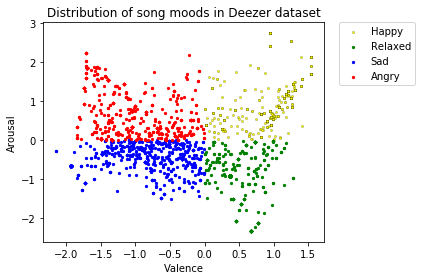

Happy songs:	 1135 	 32.29937393284007 %
Relaxed songs:	 652 	 18.554354012521344 %
Sad songs:	 1027 	 29.22595332953899 %
Angry songs:	 700 	 19.9203187250996 %


In [130]:
import matplotlib.pyplot as plt

fig = plt.figure()
viz = fig.add_subplot(111)
ptSize = 5
viz.scatter(happy_x, happy_y, s = ptSize, edgecolor='black', linewidth='0.2', color="yellow")
viz.scatter(relaxed_x, relaxed_y, s = ptSize, color="green")
viz.scatter(sad_x, sad_y, s = ptSize, color="blue")
viz.scatter(angry_x, angry_y, s = ptSize, color="red")
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.legend(['Happy', 'Relaxed', 'Sad', 'Angry'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Distribution of song moods in Deezer dataset')
plt.tight_layout()
plt.show()

num_songs = len(deezer_track_ids)
print('Happy songs:\t', len(happy_x), '\t', 100*len(happy_x)/num_songs, '%')
print('Relaxed songs:\t', len(relaxed_x), '\t', 100*len(relaxed_x)/num_songs, '%')
print('Sad songs:\t', len(sad_x), '\t', 100*len(sad_x)/num_songs, '%')
print('Angry songs:\t', len(angry_x), '\t', 100*len(angry_x)/num_songs, '%')

By dividing the valence-arousal space into 4 quadrants as per the paper on MoodyLyrics by Çano and Morisio [3], the distribution of the Deezer dataset's distinction between 4 key "bins" of mood can be distinguished. 

Each data point plotted represents the valence and arousal value of a given song. Happy (yellow) songs are positive and high energy. Relaxed (green) songs are positive and low energy. Their respective complements are: sad (blue) songs that are negative with low energy, and angry (red) songs that are negative with high energy.

The songs plotted here are all from the Deezer dataset, and these songs are chosen randomly from the MSD as long as they had sufficient tag information to do sentiment analysis with so that their corresponding valence and arousal values could be obtained. For a song to have "sufficient tag information," a song would have to have received tags of sufficient quantity and semantic significance by users to amass meaningful information about its mood content. The Deezer dataset crawled sources other than the MSD to find this crowdsourced tag information (see the paper for details). 

Knowing this, the distribution of songs can be taken to be a reasonable estimation of the mood distribution of popular songs across all genres. Because these songs are made relatively popular by a majority of listeners choosing to listen to and tag them, this distribution could by extension be seen as a representation of a generalized distribution of moods of people. This is reinforced by the tendency of people feeling a certain way wanting to listen to music with the same mood as a method for catharsis.

Angry and sad songs have lower variance about the arousal = 0 line than happy and relaxed songs (and the number of angry and sad songs is nearly equal to the number of happy and relaxed songs). This can be reflective of the relative complexity and nuance of the entire gamut of more negative emotions compared to that of positive emotions. In other words, this data suggests that there are many more "shades" of negative emotions than positive emotions.

Another observation is that happy and angry songs have higher variance in arousal than relaxed and sad songs. This is suggestive of the inherent volatility of these emotions compared to more stable, low-arousal emotions. 

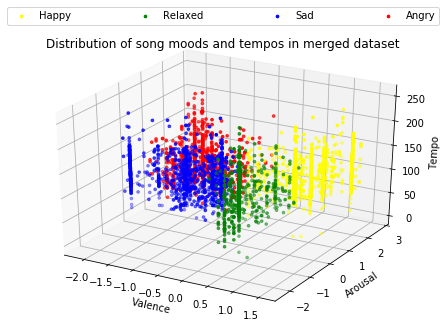

Average tempos
--------------
Happy songs:	 125  BPM
Relaxed songs:	 121  BPM
Sad songs:	 120  BPM
Angry songs:	 122  BPM


In [137]:
fig = plt.figure()
viz = Axes3D(fig)
ptSize3d = 7
viz.scatter(happy_x, happy_y, happy_tempo, s = ptSize3d, color="yellow")
viz.scatter(relaxed_x, relaxed_y, relaxed_tempo, s = ptSize3d, color="green")
viz.scatter(sad_x, sad_y, sad_tempo, s = ptSize3d, color="blue")
viz.scatter(angry_x, angry_y, angry_tempo, s = ptSize3d, color="red")
plt.xlabel('Valence')
plt.ylabel('Arousal')
viz.set_zlabel('Tempo')
plt.legend(['Happy', 'Relaxed', 'Sad', 'Angry'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)
plt.title('Distribution of song moods and tempos in merged dataset')
plt.tight_layout()
plt.show()

print('Average tempos\n--------------')
print('Happy songs:\t', int(sum(happy_tempo)/len(happy_tempo)), ' BPM')
print('Relaxed songs:\t', int(sum(relaxed_tempo)/len(relaxed_tempo)), ' BPM')
print('Sad songs:\t', int(sum(sad_tempo)/len(sad_tempo)), ' BPM')
print('Angry songs:\t', int(sum(angry_tempo)/len(angry_tempo)), ' BPM')

As expected, the average tempos for high-arousal songs like happy and angry songs are higher than the average tempos for the low-arousal songs. However, surprisingly, the average tempos are all very close together. This is likely due to how a large number of the samples from each of the 4 quadrants lie near the arousal = 0 or valence = 0 lines, possibly leading to a song that could easily be misclassified by the hard threshold. 

A clearer separation in average tempos may be observed if we take the "most emotive" songs of each set of emotions and find their average tempos. 

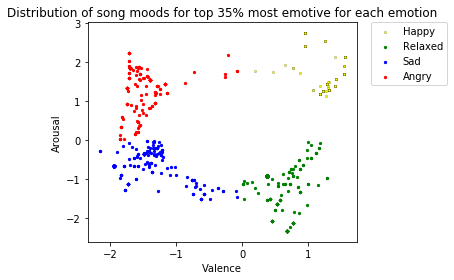

In [177]:
def get_most_emotive(emote_x, emote_y, percentile):
    num_emote = len(emote_x)

    magnitudes = np.zeros(num_emote)

    for i in range(num_emote):
        magnitudes[i] = np.linalg.norm((emote_x[i], emote_y[i]), ord=2)

    magnitudesSorted = sorted(magnitudes)
    cutoff = magnitudesSorted[int((num_emote-1)*percentile)]

    most_emotive_x = [emote_x[i] for i in range(num_emote) if np.linalg.norm((emote_x[i], emote_y[i]), ord=2) >= cutoff]
    most_emotive_y = [emote_y[i] for i in range(num_emote) if np.linalg.norm((emote_x[i], emote_y[i]), ord=2) >= cutoff]
    
    return most_emotive_x, most_emotive_y

p = 0.65
happiest_x, happiest_y = get_most_emotive(happy_x, happy_y, p)
relaxedest_x, relaxedest_y = get_most_emotive(relaxed_x, relaxed_y, p) # Yeah, not a word, but to keep naming convention...
saddest_x, saddest_y = get_most_emotive(sad_x, sad_y, p)
angriest_x, angriest_y = get_most_emotive(angry_x, angry_y, p)


fig = plt.figure()
viz = fig.add_subplot(111)
ptSize = 5
viz.scatter(happiest_x, happiest_y, s = ptSize, edgecolor='black', linewidth='0.2', color="yellow")
viz.scatter(relaxedest_x, relaxedest_y, s = ptSize, color="green")
viz.scatter(saddest_x, saddest_y, s = ptSize, color="blue")
viz.scatter(angriest_x, angriest_y, s = ptSize, color="red")
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.legend(['Happy', 'Relaxed', 'Sad', 'Angry'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_title = str('Distribution of song moods for top ' + str(int((1-p)*100)) + '% most emotive for each emotion')
plt.title(plot_title)
plt.tight_layout()
plt.show()


In other words, this is the distribution of songs that are more confidently one emotion or the other.

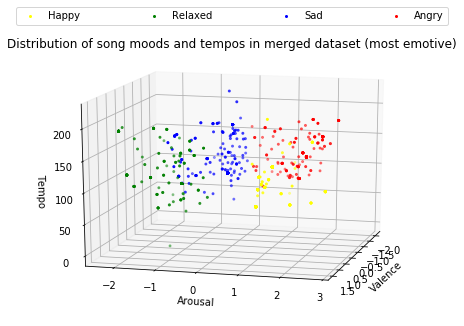

Average tempos (most emotive)
----------------------------
Happy songs:	 125  BPM
Relaxed songs:	 109  BPM
Sad songs:	 106  BPM
Angry songs:	 130  BPM


In [175]:
happiest_tempos = []
relaxedest_tempos = []
saddest_tempos = []
angriest_tempos = []

for i in range(len(happiest_x)):
    tmp_idx = happy_x.index(happiest_x[i])
    happiest_tempos.append(happy_tempo[tmp_idx])
    
for i in range(len(relaxedest_x)):
    tmp_idx = relaxed_x.index(relaxedest_x[i])
    relaxedest_tempos.append(relaxed_tempo[tmp_idx])
    
for i in range(len(saddest_x)):
    tmp_idx = sad_x.index(saddest_x[i])
    saddest_tempos.append(sad_tempo[tmp_idx])
    
for i in range(len(angriest_x)):
    tmp_idx = angry_x.index(angriest_x[i])
    angriest_tempos.append(angry_tempo[tmp_idx])

fig = plt.figure()
viz = Axes3D(fig)
ptSize3d = 4
viz.scatter(happiest_x, happiest_y, happiest_tempos, s = ptSize3d, color="yellow")
viz.scatter(relaxedest_x, relaxedest_y, relaxedest_tempos, s = ptSize3d, color="green")
viz.scatter(saddest_x, saddest_y, saddest_tempos, s = ptSize3d, color="blue")
viz.scatter(angriest_x, angriest_y, angriest_tempos, s = ptSize3d, color="red")
plt.xlabel('Valence')
plt.ylabel('Arousal')
viz.set_zlabel('Tempo')
plt.legend(['Happy', 'Relaxed', 'Sad', 'Angry'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)
plt.title('Distribution of song moods and tempos in merged dataset (most emotive)')
plt.tight_layout()

viz.azim = 15
viz.elev = 15

plt.show()

print('Average tempos (most emotive)\n----------------------------')
print('Happy songs:\t', int(sum(happiest_tempos)/len(happiest_tempos)), ' BPM')
print('Relaxed songs:\t', int(sum(relaxedest_tempos)/len(relaxedest_tempos)), ' BPM')
print('Sad songs:\t', int(sum(saddest_tempos)/len(saddest_tempos)), ' BPM')
print('Angry songs:\t', int(sum(angriest_tempos)/len(angriest_tempos)), ' BPM')

By taking the 35% most emotive of each of the 4 emotions, a clearer separation in BPM between high- and low-arousal songs can be observed. 

When choosing ideal running music, higher-arousal songs will be matched up to more intensive running, and lower-arousal songs can be matched to more easy-going running or warm-up/cool-down.

## Conclusions and on moving forward

Now that a dataset combining representative emotional content of a song and tempo has been created using existing datasets, activity recognition to differentiate between states of jogging and not jogging can be investigated and implemented. This work on making use of a user's mood and activity state (acquired by heart rate sensor and accelerometer, respectively) can be extended to any number of data acquisition methods using this general framework of mapping emotions and tempo to songs. 

This can likely forge a more immersive music recommendation experience when used alongside traditional methods than through traditional methods alone (collaborative filtering, content-based filtering).

Generally the songs' valence/arousal values match up with their respective classification. However, in music, there is always room for subjectivity. Perhaps a new tempo extracting algorithm can be developed and implemented to more reliably extract tempo from songs. One would have to account for a song's changes in tempo (and how to represent it: as a weighted average, or an array of the tempos), and one would have to distinguish between quarter notes and eighth notes that make up the rhythmic backbone of most popular music (else risk extracting double or half the original tempo by basing the quarter note on the wrong notes).

## References

[1] Delbuoys, Remi, et al. “Music Mood Detection Based On Audio And Lyrics With Deep Neural Net.” In: ISMIR, 2018.

[2] Bertin-Mahieux, Thierry et al. "The million song dataset." In: ISMIR, 2011.

[3] Çano, Erion; Morisio, Maurizio. "MoodyLyrics: A Sentiment Annotated Lyrics Dataset." In: 2017 International Conference on Intelligent Systems, Metaheuristics & Swarm Intelligence, Hong Kong, March, 2017.